#### Universidade Federal de Campina Grande
#### Departamento de Sistemas e Computação
#### Lucas Nascimento Cabral
#### Previsão de Votação

#### (1) Análise dos dados

Para começarmos, iremos analisar os dados disponibilizados pelo professor afim de verificarmos as distribuições das variáveis para ver se estão enviesadas e precisam de correção, realizar tratamento de valores ausentes, variáveis categóricas e normalização, se for o caso.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

data = pd.read_csv("eleicoes_2006_a_2010.csv")
teste = pd.read_csv("eleicoes_2014.csv")

data.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


Como podemos observar nas 5 primeiras linhas que a função head nos traz, temos valores NaN em algumas células, valores numéricos distorcidos e precisamos tratar as váriaveis categóricas.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001942CB83668>,
      dtype=object)

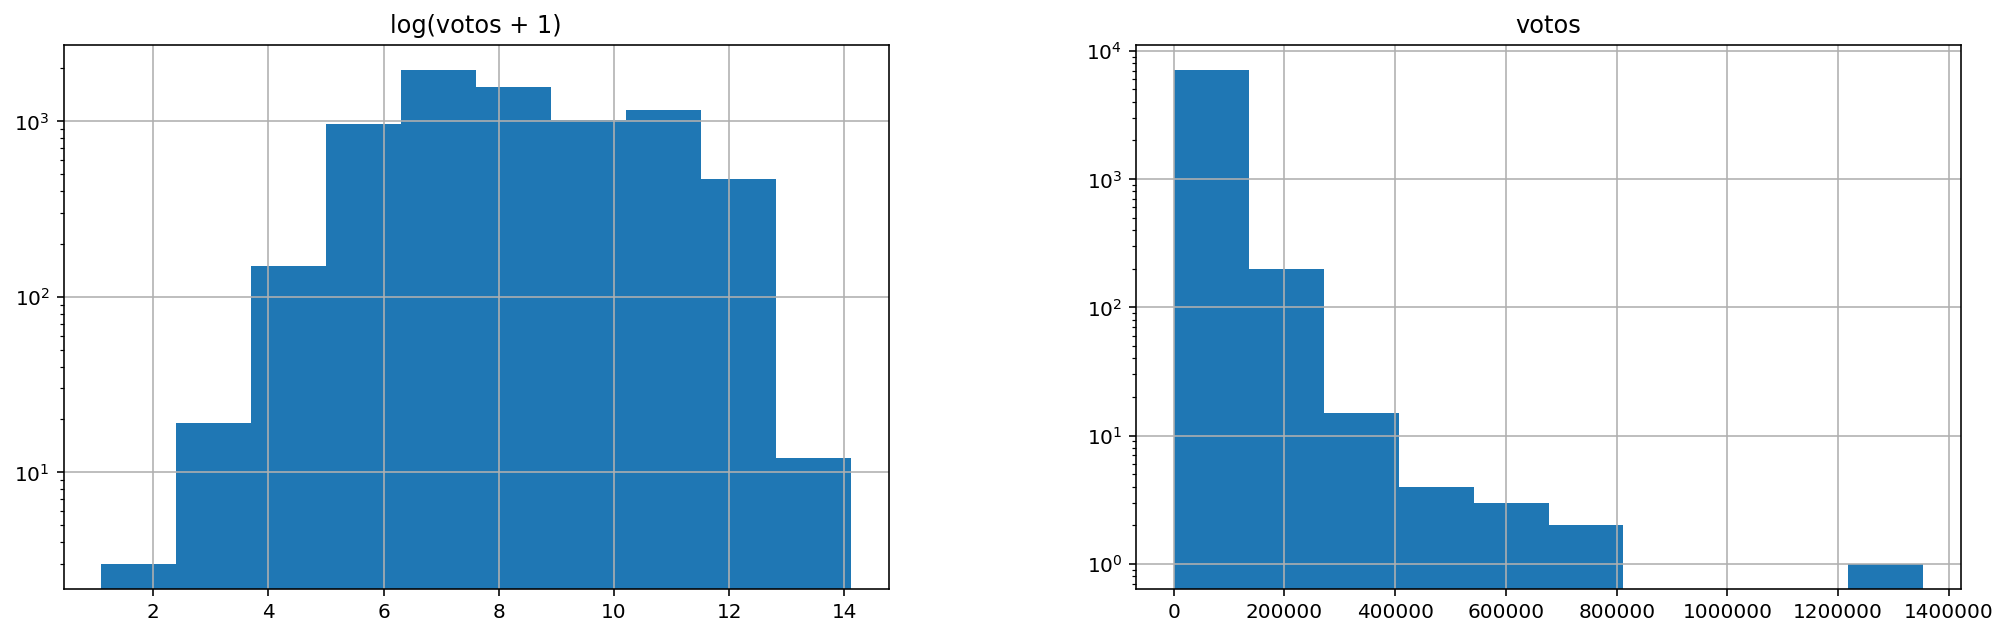

In [2]:
matplotlib.rcParams['figure.figsize'] = (17.0, 5.0)

votos = pd.DataFrame({"votos":data["votos"], "log(votos + 1)":np.log1p(data["votos"])})
votos.hist(log=True)

Atributos desnecessários como sequencial_candidato, media_receita, media_despesas e nome podem ser removidos.

In [3]:
data = data.drop(columns=['sequencial_candidato','media_receita','media_despesa','nome'])

teste = teste.drop(columns=['sequencial_candidato','media_receita','media_despesa','nome'])

Aplicando normalização em todas as variáveis numéricas, exceto ano, por ser considerada como ordinal

In [4]:
#log transform skewed numeric features
data = data.fillna(data.mean())

numeric_feats = data.dtypes[data.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')

data[numeric_feats] = np.log1p(data[numeric_feats])

# para o teste
teste = teste.fillna(teste.mean())

numeric_feats = teste.dtypes[teste.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')

teste[numeric_feats] = np.log1p(teste[numeric_feats])

Para que os dados de todas as eleições possuam as mesmas colunas juntei os dados de todas as eleições

In [5]:
allData = pd.concat((teste,data))

teste_entradas = allData.loc[:,:'ocupacao']
teste_entradas = pd.get_dummies(teste_entradas)

entradas = teste_entradas.loc[teste_entradas['ano'] != 2014]
teste_entradas = teste_entradas.loc[teste_entradas['ano'] == 2014]

saida = allData.loc[allData['ano'] != 2014]
saida = saida.loc[:,'votos']

alvo = allData.loc[allData['ano'] == 2014]
alvo = alvo.loc[:,'votos']

Função dummy nas variáveis categóricas e preenchimento de valores NaN com a média dos valores da coluna.
Dividisão dos dados em dados de treino e teste aleatoriamente, com proporção de 75% para treino e 25% para validação.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(entradas, saida, test_size=0.25, random_state = 12)

#### (2) Modelos

Imports necessários para a construção dos modelos de Regressão Linear, Ridge, Lasso, KNN, Random Forest, Tree Regressor e SVR

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

Método para calcular o rmse com validação cruzada:

In [8]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

#### (2.1) Regressão Linear

In [9]:
reg_linear = LinearRegression()
reg_linear.fit(X_train, Y_train)

print(rmse_cv(reg_linear).mean())

274263368.170975


#### (2.2) Ridge

Text(0,0.5,'rmse')

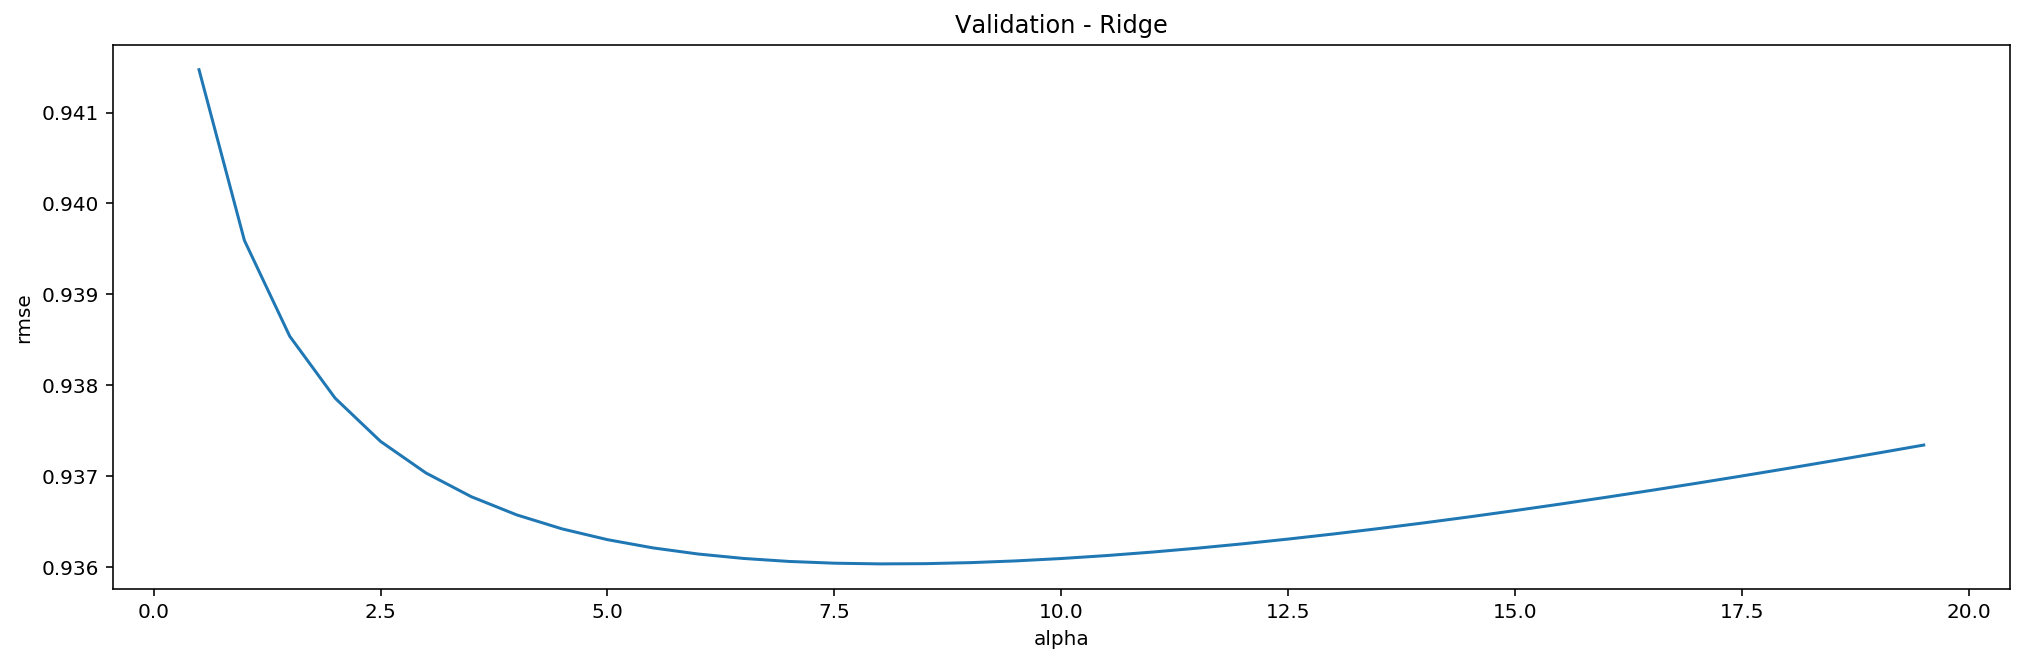

In [10]:
alphas_ridge = np.arange(0.5,20,0.5).tolist()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas_ridge]
cv_ridge = pd.Series(cv_ridge, index = alphas_ridge)

cv_ridge.plot(title = "Validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [11]:
print('Para o modelo de Regressão Ridge obtivemos um rmse por volta de: {}'.format(cv_ridge.min()))

Para o modelo de Regressão Ridge obtivemos um rmse por volta de: 0.9360376679234035


#### (2.3) Lasso

Text(0,0.5,'rmse')

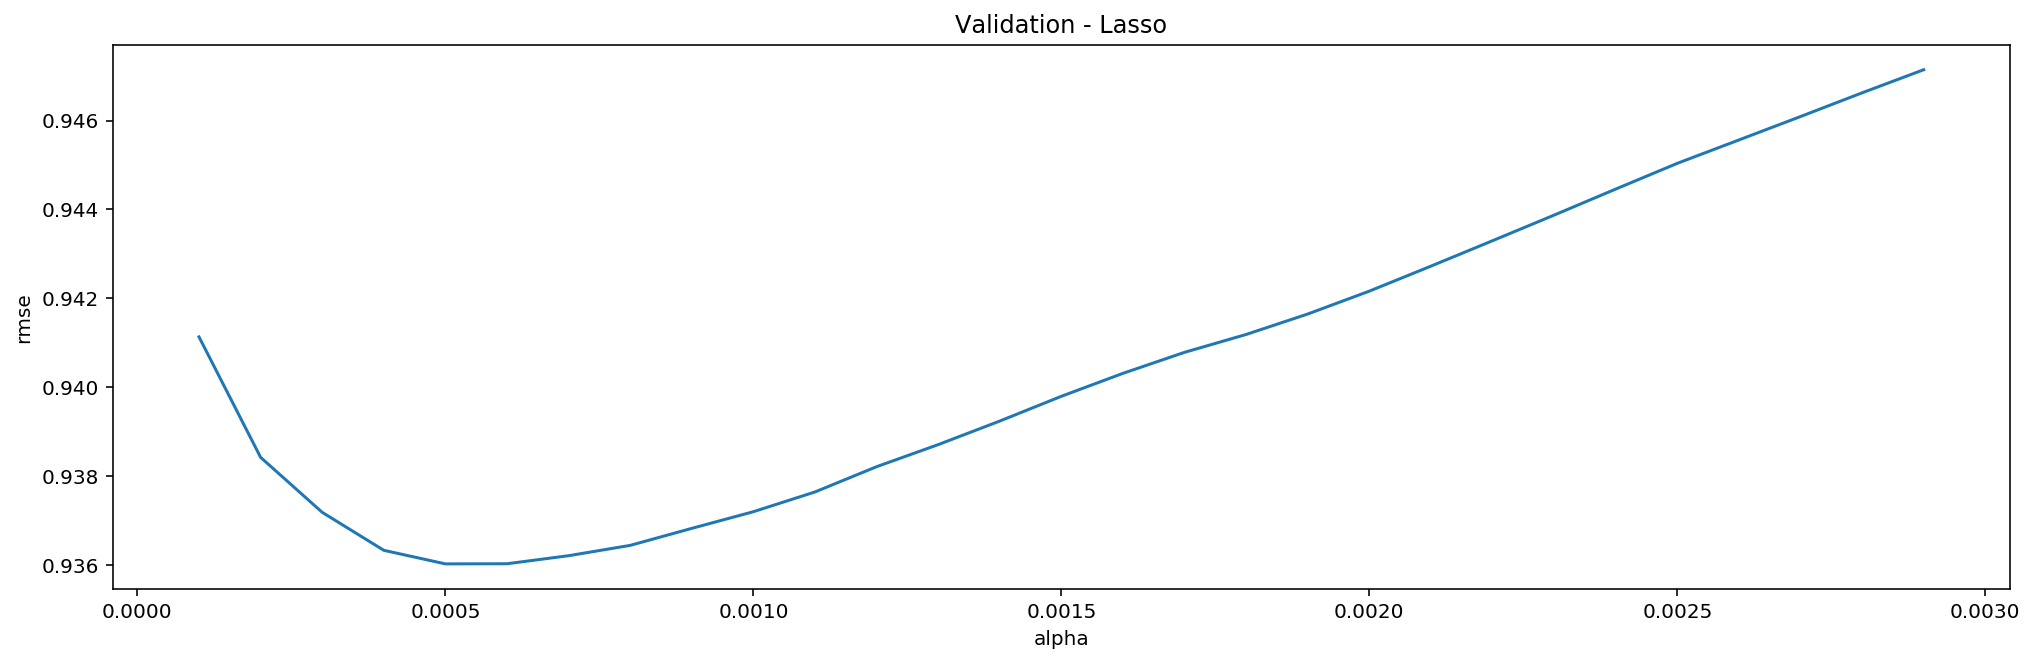

In [12]:
alphas_lasso = np.arange(0.0001,0.003,0.0001).tolist()

cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=10000)).mean()
            for alpha in alphas_lasso]

cv_lasso = pd.Series(cv_lasso, index = alphas_lasso)
cv_lasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [13]:
print('Para o modelo de Regressão Lasso obtivemos um rmse por volta de: {}'.format(cv_lasso.min()))

Para o modelo de Regressão Lasso obtivemos um rmse por volta de: 0.9360203009777441


#### (2.4) KNN

Text(0,0.5,'rmse')

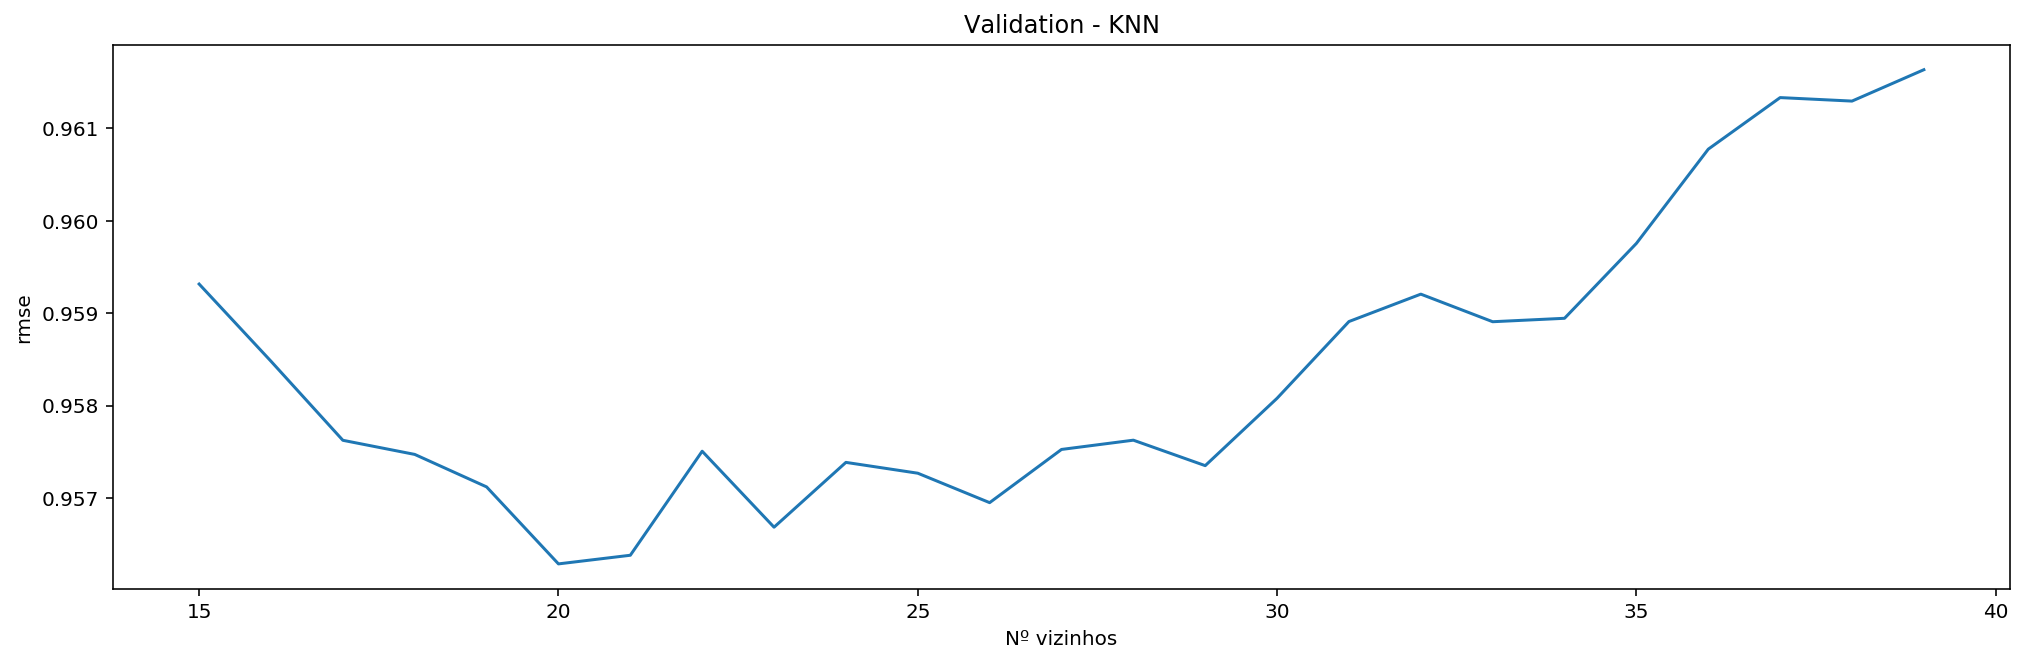

In [14]:
k_list = np.arange(15,40,1).tolist()

cv_knn = [rmse_cv(KNeighborsRegressor(n_neighbors = n)).mean()
            for n in k_list]

cv_knn = pd.Series(cv_knn, index = k_list)
cv_knn.plot(title = "Validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("rmse")

In [15]:
print('Para o modelo KNN obtivemos um rmse por volta de: {}'.format(cv_knn.min()))

Para o modelo KNN obtivemos um rmse por volta de: 0.9562861615352173


#### (2.5) Random Forest

Text(0,0.5,'rmse')

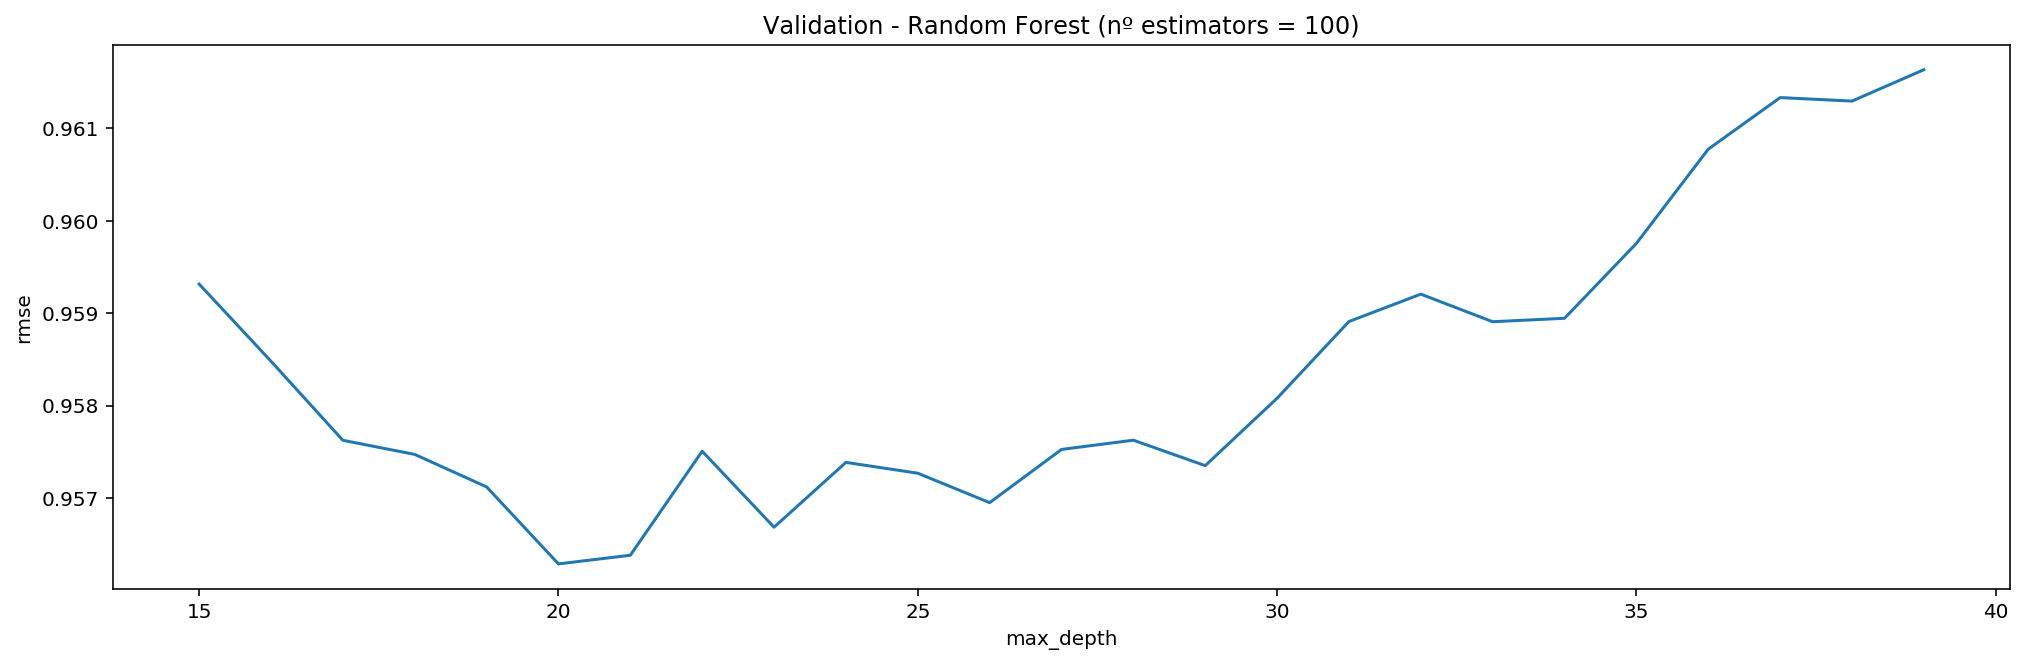

In [16]:
depth_list = np.arange(2,10,1).tolist()

cv_forest = [rmse_cv(RandomForestRegressor(max_depth = max_depth, n_estimators=100)).mean()
            for max_depth in depth_list]

cv_forest = pd.Series(cv_knn, index = k_list)
cv_forest.plot(title = "Validation - Random Forest (nº estimators = 100)")
plt.xlabel("max_depth")
plt.ylabel("rmse")

In [17]:
print('Para o modelo Random Forest obtivemos um rmse por volta de: {}'.format(cv_forest.min()))

Para o modelo Random Forest obtivemos um rmse por volta de: 0.9562861615352173


#### (2.6) Tree Regressor

Text(0,0.5,'rmse')

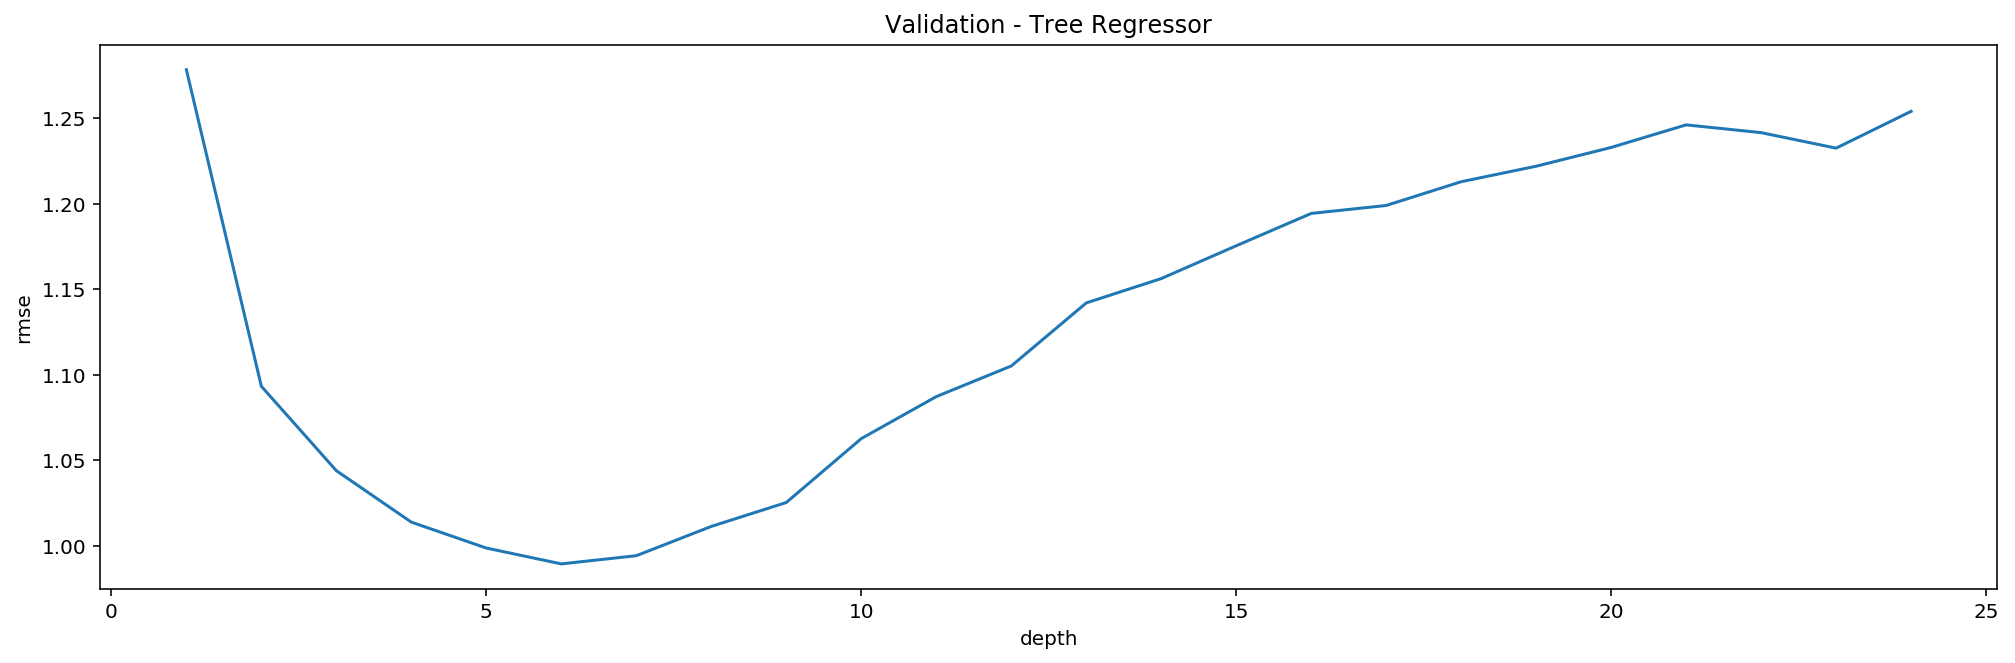

In [18]:
depths = np.arange(1,25,1).tolist()

cv_treeregressor = [rmse_cv(DecisionTreeRegressor(max_depth = depth )).mean() 
            for depth in depths]

cv_treeregressor = pd.Series(cv_treeregressor, index = depths)
cv_treeregressor.plot(title = "Validation - Tree Regressor")
plt.xlabel("depth")
plt.ylabel("rmse")

In [19]:
print('Para o modelo Tree Regressor obtivemos um rmse por volta de: {}'.format(cv_treeregressor.min()))

Para o modelo Tree Regressor obtivemos um rmse por volta de: 0.9895174253185604


#### (2.7) Support Vector Regression (SVR)

In [20]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, Y_train)

print(rmse_cv(regressor).min())

0.870239332377594


Ao final, obtivemos os seguintes rmses de validação cruzada para os modelos construidos:

|    Modelo      |         rmse          | 
|----------------|-----------------------|
|Regressão Linear|    274263368.1709     | 
|     Ridge      |        0.9360         |  
|     Lasso      |        0.9360         | 
|      KNN       |        0.9562         |      
| Random Forest  |        0.9562         | 
| Tree Regressor |        0.9895         |  
|      SVR       |        0.8702         |  

#### (3) Resíduos x Predições:

#### (3.1) Regressão Linear

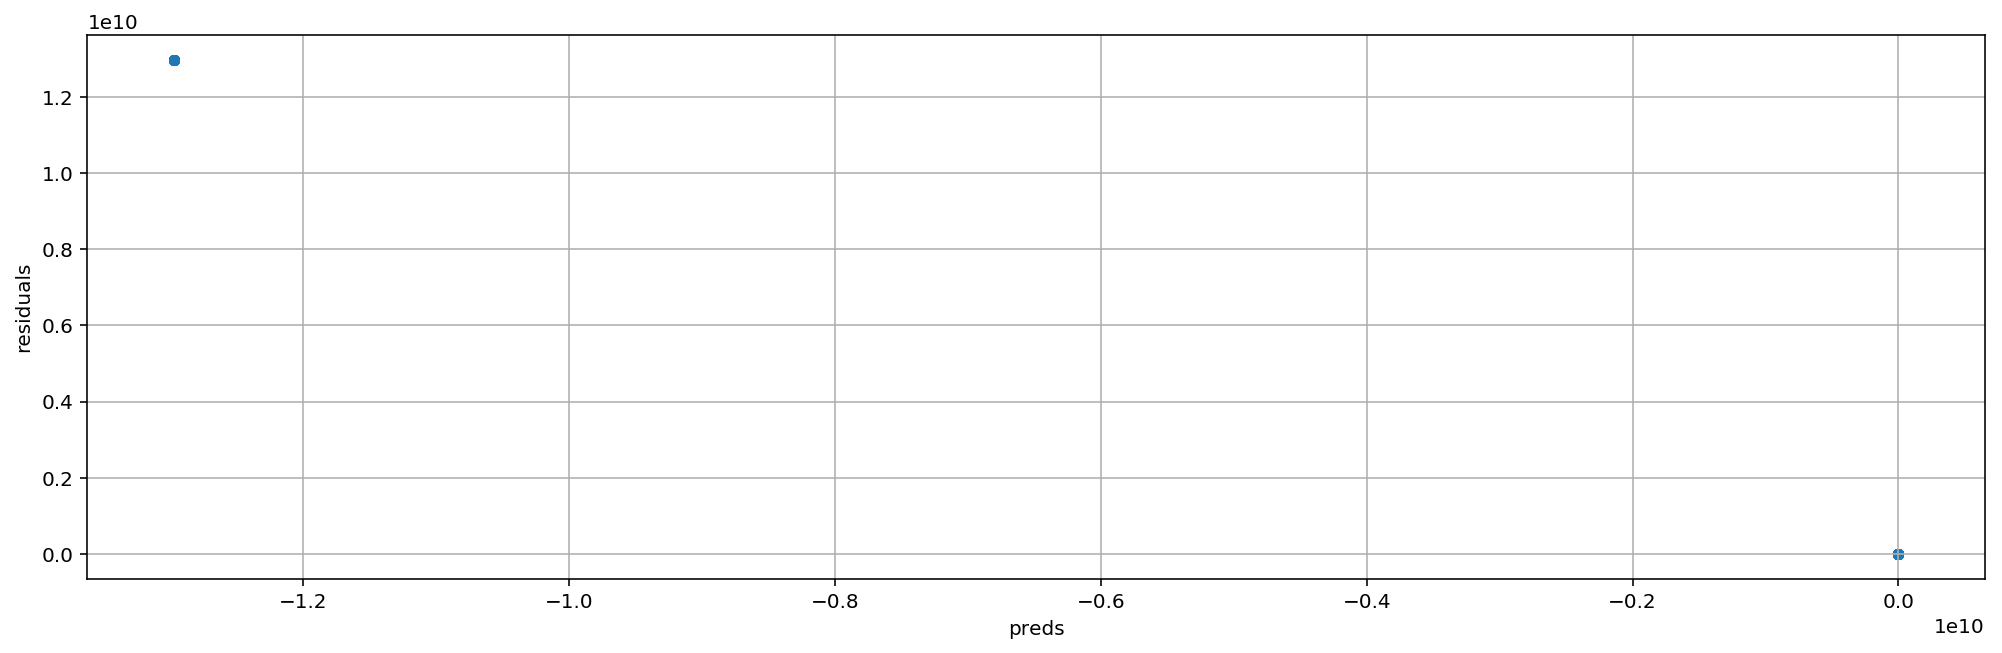

In [21]:
model_reg_linear = LinearRegression().fit(X_train, Y_train)
preds = pd.DataFrame({"preds": model_reg_linear.predict(X_validation), "true":Y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", grid=True)

#### (3.2) Ridge

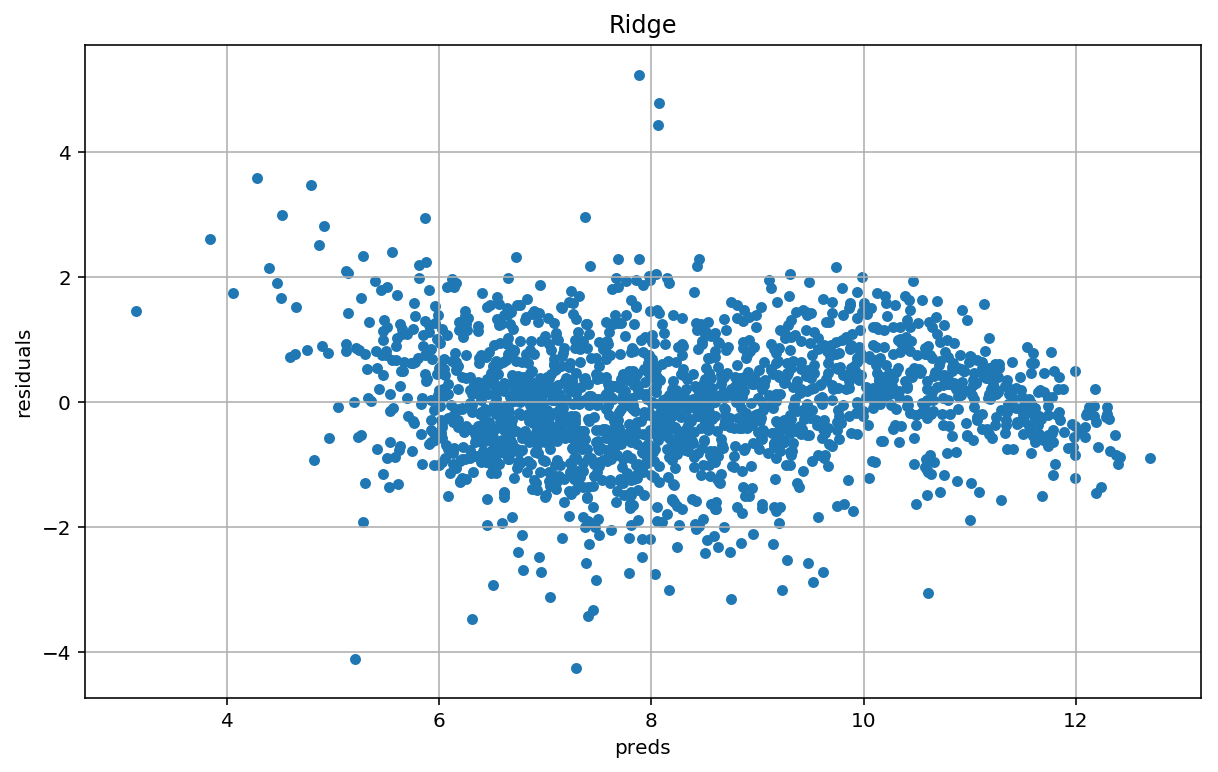

In [22]:
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(X_train,Y_train)

preds_ridge = pd.DataFrame({"preds":model_ridge.predict(X_validation), "true":Y_validation})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
x = preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

#### (3.3) Lasso

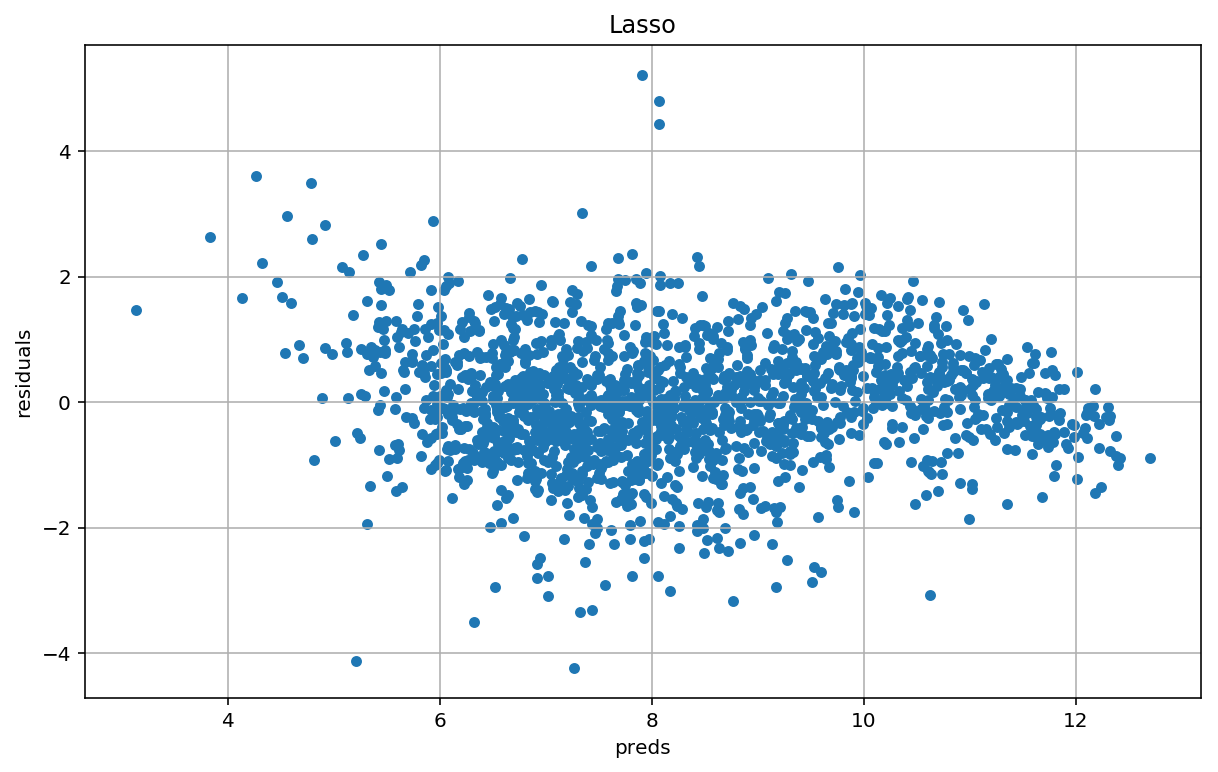

In [23]:
model_lasso = Lasso(alpha = cv_lasso.idxmin())
model_lasso.fit(X_train,Y_train)

preds_lasso = pd.DataFrame({"preds":model_lasso.predict(X_validation), "true":Y_validation})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

#### (3.4) KNN

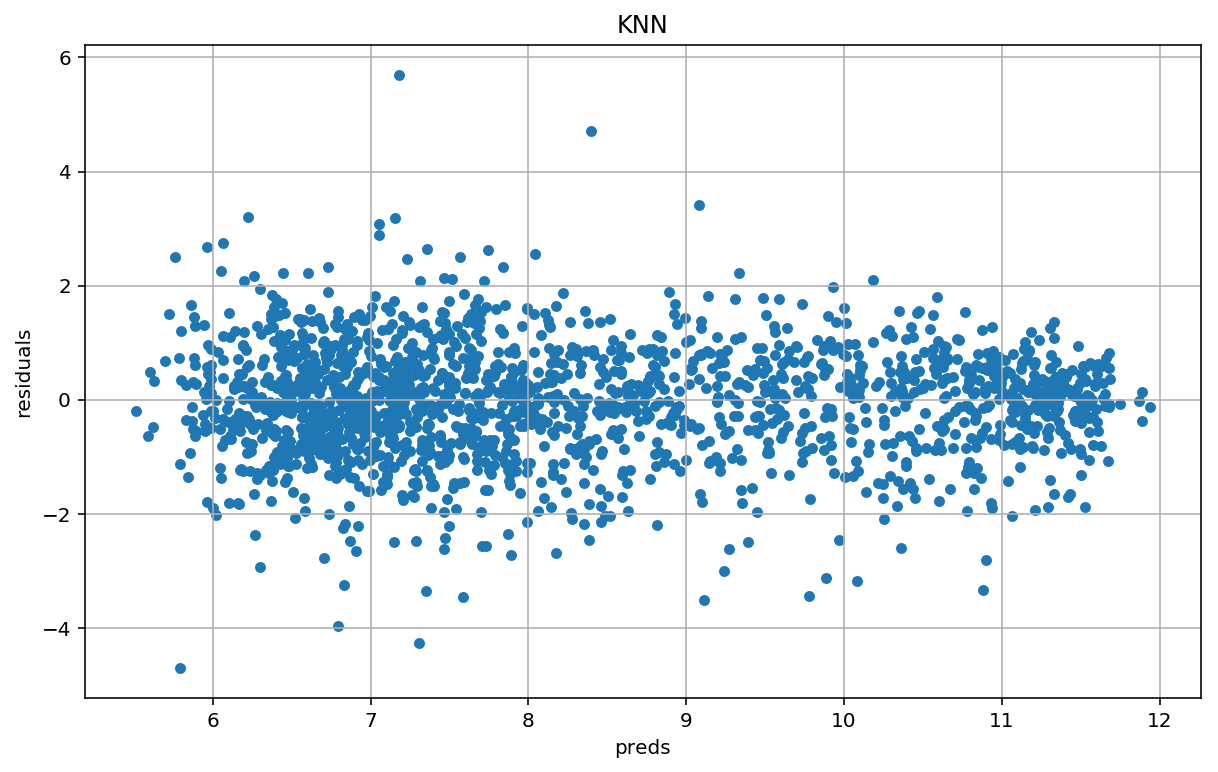

In [24]:
model_knn = KNeighborsRegressor(cv_knn.idxmin())
model_knn.fit(X_train,Y_train)

preds_knn = pd.DataFrame({"preds":model_knn.predict(X_validation), "true":Y_validation})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

#### (3.5) Random Forest

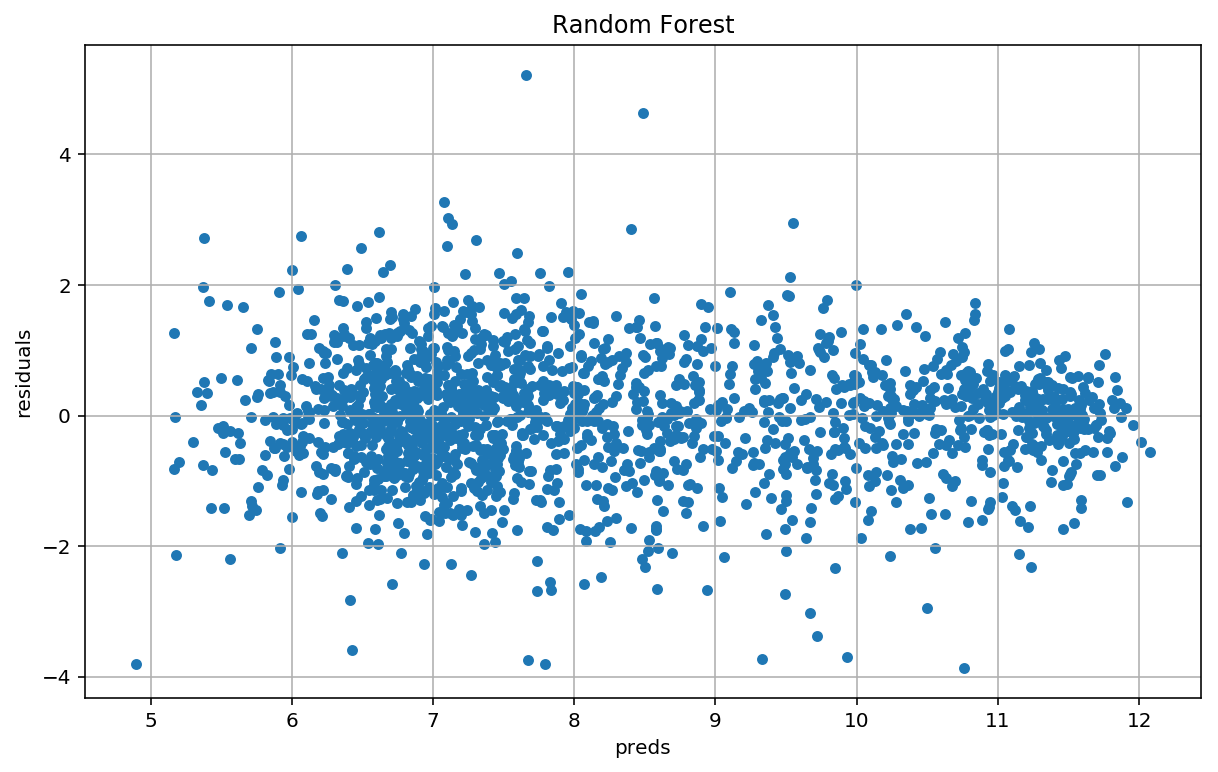

In [25]:
model_forest = RandomForestRegressor(cv_forest.idxmin())
model_forest.fit(X_train,Y_train)

preds_forest = pd.DataFrame({"preds":model_forest.predict(X_validation), "true":Y_validation})
preds_forest["residuals"] = preds_forest["true"] - preds_forest["preds"]
preds_forest.plot(x = "preds", y = "residuals",kind = "scatter", title = "Random Forest", grid = True)

#### (3.6) Tree Regressor

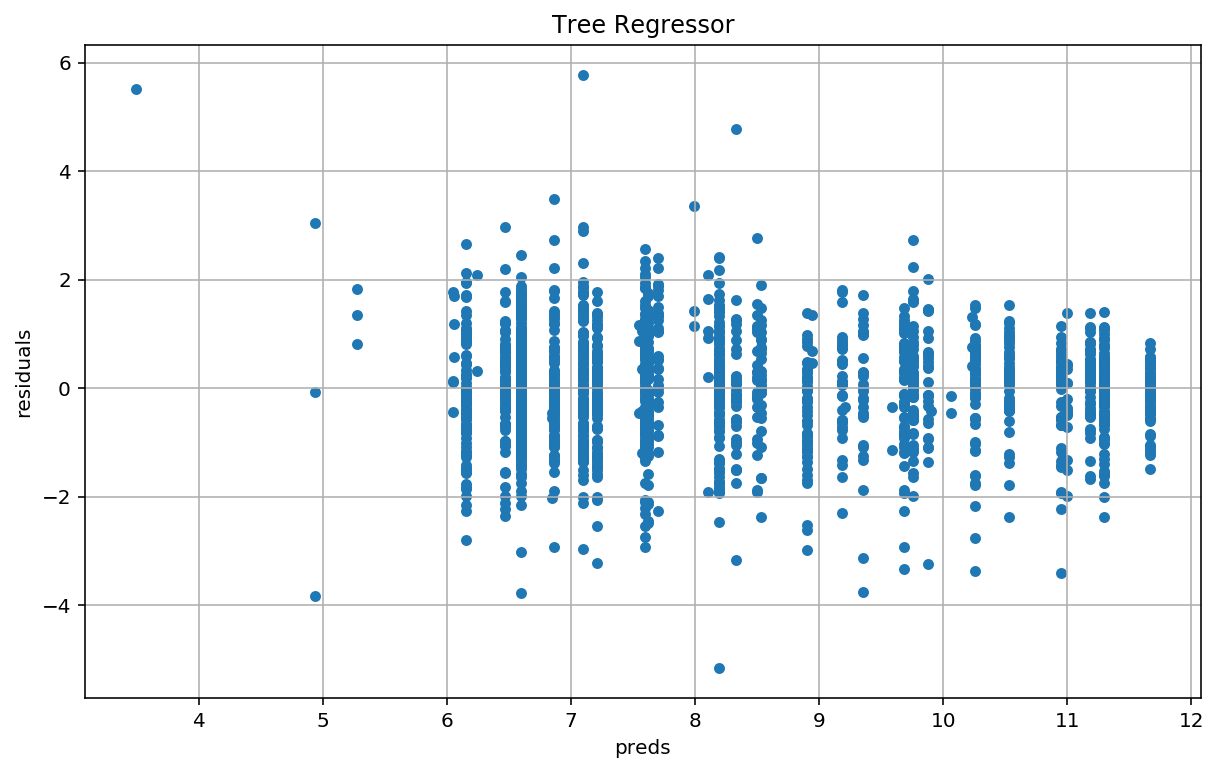

In [26]:
model_tree = DecisionTreeRegressor(max_depth = cv_treeregressor.idxmin()).fit(X_train, Y_train)
preds = pd.DataFrame({"preds": model_tree.predict(X_validation), "true":Y_validation})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter", title = "Tree Regressor",  grid=True)

#### (4) Responder:
#### Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

#### (3.1) Ridge

In [27]:
realTeste_alvo = np.expm1(alvo)

Para o modelo Ridge obtivemos um rmse por volta de: 1.699506394626295


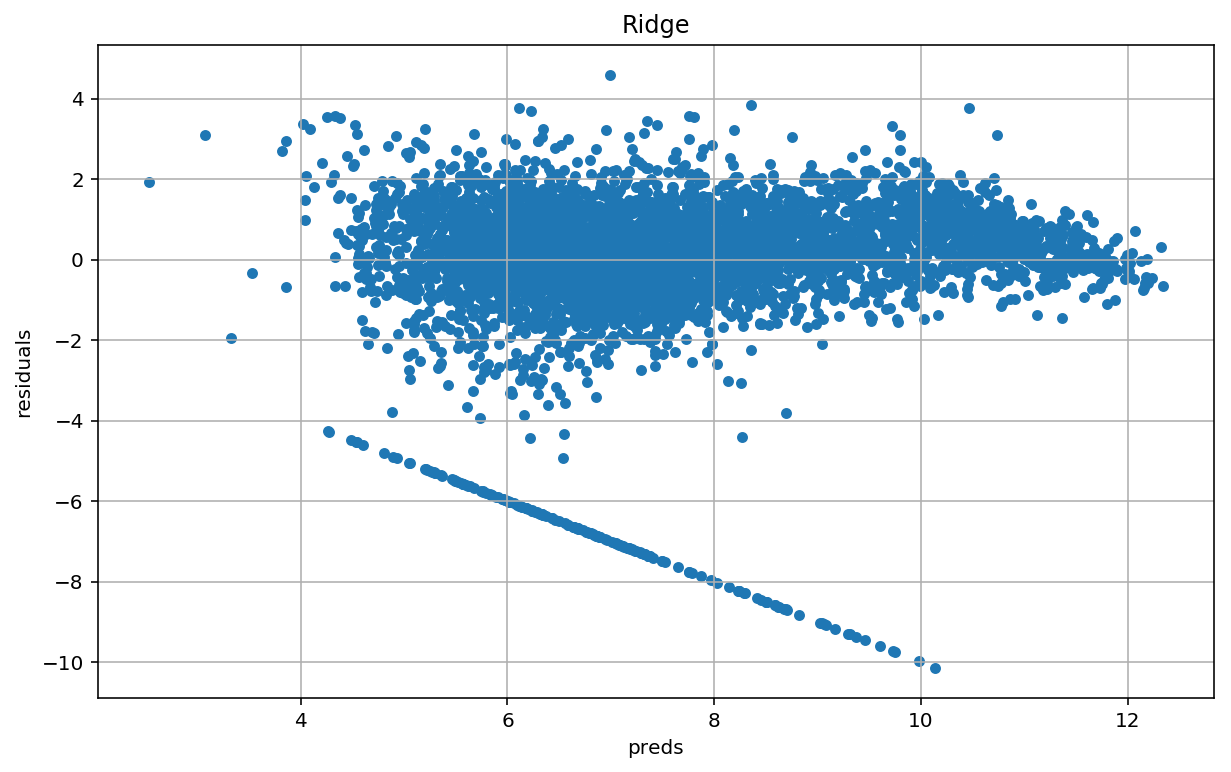

In [28]:
model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(entradas, saida)

preds_ridge = pd.DataFrame({"preds":model_ridge.predict(teste_entradas), "true":alvo})
preds_ridge["residuals"] = preds_ridge["true"] - preds_ridge["preds"]
preds_ridge.plot(x = "preds", y = "residuals",kind = "scatter", title = "Ridge", grid = True)

rmse = np.sqrt(mean_squared_error(preds_ridge["true"],preds_ridge["preds"]))

print('Para o modelo Ridge obtivemos um rmse por volta de: {}'.format(rmse))

#### (3.2) Lasso

Para o modelo Lasso obtivemos um rmse por volta de: 1.6984080939249655


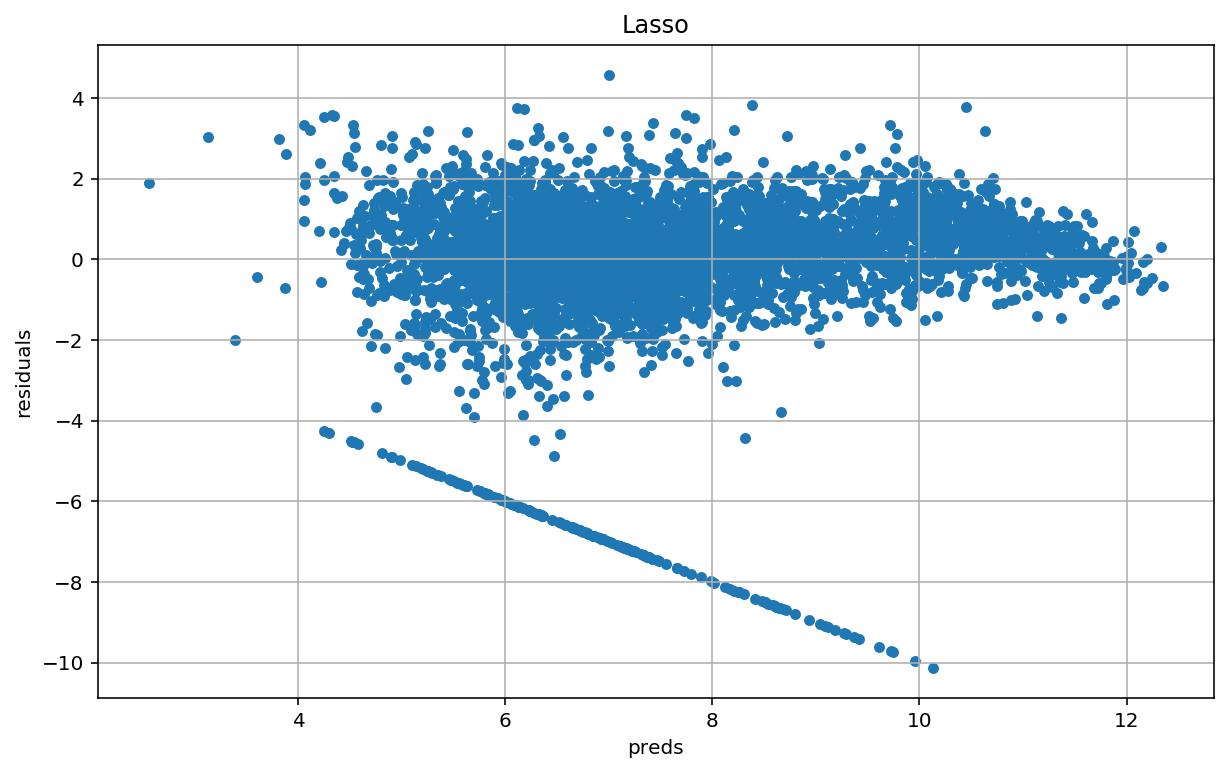

In [29]:
model_lasso = Lasso(alpha = cv_lasso.idxmin())
model_lasso.fit(entradas, saida)

preds_lasso = pd.DataFrame({"preds":model_lasso.predict(teste_entradas), "true":alvo})
preds_lasso["residuals"] = preds_lasso["true"] - preds_lasso["preds"]
x = preds_lasso.plot(x = "preds", y = "residuals",kind = "scatter", title = "Lasso", grid = True)

rmse = np.sqrt(mean_squared_error(preds_lasso["true"],preds_lasso["preds"]))

print('Para o modelo Lasso obtivemos um rmse por volta de: {}'.format(rmse))

#### (3.3) KNN

Para o modelo KNN obtivemos um rmse por volta de: 1.8145467597929423


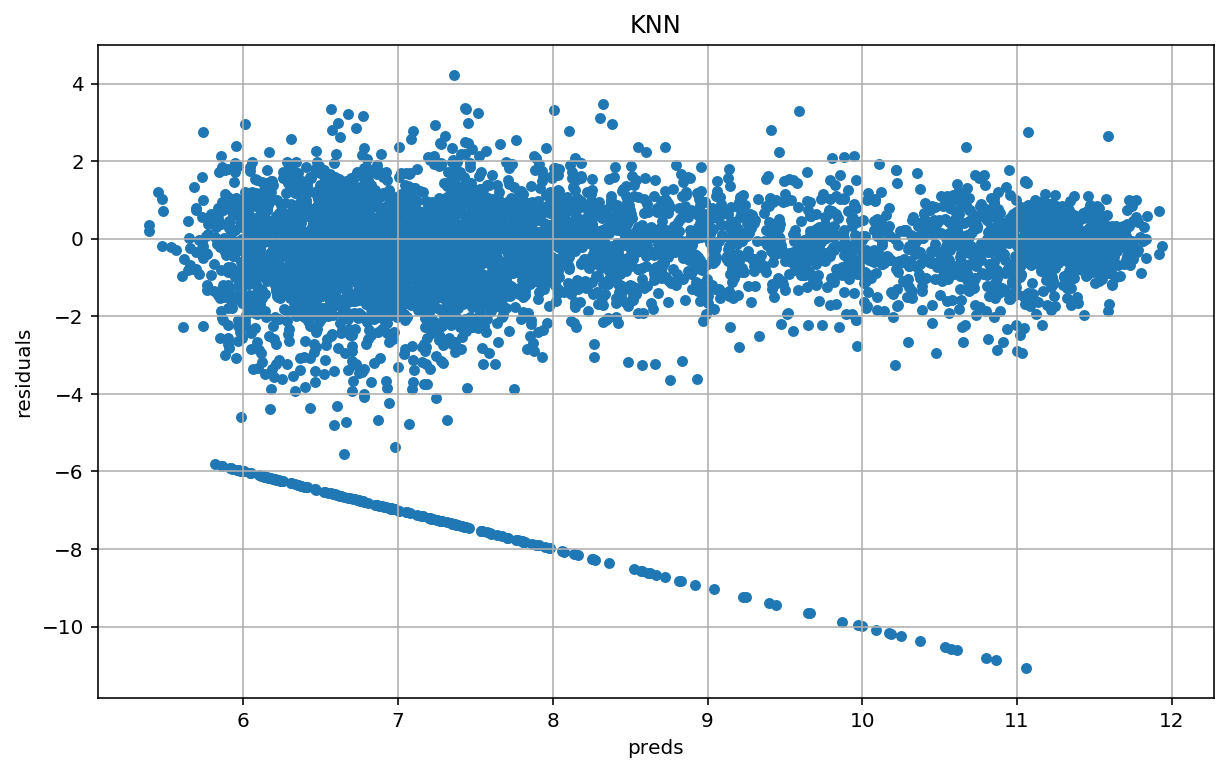

In [30]:
model_knn = KNeighborsRegressor(n_neighbors=cv_knn.idxmin())
model_knn.fit(entradas, saida)

preds_knn = pd.DataFrame({"preds":model_knn.predict(teste_entradas), "true":alvo})
preds_knn["residuals"] = preds_knn["true"] - preds_knn["preds"]
x = preds_knn.plot(x = "preds", y = "residuals",kind = "scatter", title = "KNN", grid = True)

rmse = np.sqrt(mean_squared_error(preds_knn["true"],preds_knn["preds"]))

print('Para o modelo KNN obtivemos um rmse por volta de: {}'.format(rmse))

#### Conclusões

Ao final, obtivemos os seguintes rmses para os modelos construidos:

|    Modelo      |         rmse          | 
|----------------|-----------------------|
|     Ridge      |        1.6995         |  
|     Lasso      |        1.6984         | 
|      KNN       |        1.8145         |      
